### We're now ready to explore our research question: What are key transcriptomic features that drive the transition from primary tumor to lymph node metastasis in breast cancer?
---

### Starting Analysis from Validated Data

After preprocessing, all analyses begin with a validated dataset, ensuring consistency and reproducibility. From this point, we can explore various analytical paths, such as dimensionality reduction, clustering, differential expression analysis, or graph-based modeling, depending on the research objectives. By working with a well-structured and schema-compliant dataset, we streamline the analysis process and increase the robustness of our analysis.

In [1]:
import lamindb as ln
import bionty as bt

→ connected lamindb: paupaiz/data


In [2]:
ln.track()

→ updated transform description, loaded Transform('scVKRrxDYWG60000'), re-started Run('lxytpVhs...') at 2025-03-09 21:50:19 UTC
→ notebook imports: anndata==0.11.3 bionty==1.1.0 captum==0.7.0 lamindb==1.1a1 matplotlib==3.10.0 numpy==2.1.0 pandas==2.2.3 scanpy==1.11.0 scipy==1.14.1 scvi-tools==1.2.2.post2 seaborn==0.13.2 torch-geometric==2.6.1 torch==2.6.0 tqdm==4.67.1


In [3]:
import os
from pathlib import Path
import pandas as pd
import scanpy as sc
import anndata
import scipy.sparse as sp
from tqdm import tqdm

Anyone looking to start the analysis from (filtered) data can search the artifacts registry and retrieve the .h5ad file containing the filtered matrix.

In [4]:
#search
ln.Artifact.features.filter(experiment__icontains="Breast Cancer").df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
1,fqDEKvRwg55UfKxG0000,None,breast metastasis,.h5ad,dataset,AnnData,124511524,AFTJoMzP5ERzpiMqjr1qR3,None,108038,sha1-fl,True,False,1,1,None,None,True,2,2025-03-05 21:28:29.211000+00:00,1,None,1
2,NfPayTupzUQ5YEem0000,None,breast metastasis,.h5ad,dataset,AnnData,982219738,q4mdUBZZH_DE65t29RY5UG,None,117481,sha1-fl,True,False,1,1,None,None,True,2,2025-03-06 13:44:05.173000+00:00,1,None,1
3,RBne2GLn0c2Kie4m0000,None,Single Cell RNA-seq dataset from GEO [GSE18028...,.h5ad,dataset,AnnData,88714646,I1T5VMQKYd8saSGwJQaBbF,None,42049,sha1-fl,True,False,1,1,None,None,True,4,2025-03-06 13:54:32.873000+00:00,1,None,1


In [5]:
adata_artifact = ln.Artifact.get("RBne2GLn0c2Kie4m0000")

In [16]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'RBne2GLn0c2Kie4m0000'
│   ├── .size = 88714646
│   ├── .hash = 'I1T5VMQKYd8saSGwJQaBbF'
│   ├── .n_observations = 42049
│   ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/RBne2GLn0c2Kie4m0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-06 07:54:32
│   └── .transform = 'Preprocessing Raw data and some EDA'
├── Linked features
│   └── disease                     cat[bionty.Disease]        breast cancer                            
│       author                      str                        Xu K                                     
│       experiment                  str                        Breast Cancer scRNA-seq Experiment       
│       n_cells                     int                        42049                                    
│       n_genes                     int                        2000                                     
└── Labels
    └── .tissues                    bionty.Tissue              breast, lymph node                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Filtered

In [6]:
adata = adata_artifact.load()
adata

AnnData object with n_obs × n_vars = 42049 × 2000
    obs: 'patient', 'site', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    layers: 'counts'

### Starting the ML Workflow & Saving Model Artifacts

From this point, we initiate a machine learning (ML) workflow for single-cell analysis, ensuring that all model artifacts are saved with annotations.

Our example workflow follows these key steps:

- Extract latent representations from scRNA-seq data using scVI. [This can be compute intensive and we save these in our data]
- Construct a bipartite cell-gene graph, capturing relationships between cells and genes.
- Train a Heterogeneous Graph Neural Network (GNN) for cell classification, leveraging structured graph information.
- Interpret model predictions using Integrated Gradients (IG) to gain insights into feature importance.

By saving trained models and artifacts with metadata, we ensure that future analyses can easily reuse, validate, or extend the workflow without retraining from scratch.

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scvi
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv
from captum.attr import IntegratedGradients
import copy

/Users/paulinampaiz/.local/share/mamba/envs/lamin/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Preprocess and Extract Latent Representation Using scVI
---
Prepare scVI Model and Train to extract Latent representations

In [12]:
def train_scvi_model(adata, batch_key="patient", layer="counts", epochs=5):
    """Prepares and trains an scVI model to extract latent representations."""
    scvi.model.SCVI.setup_anndata(adata, batch_key=batch_key, layer=layer)
    model = scvi.model.SCVI(adata, gene_likelihood='nb', dispersion="gene")
    model.train(max_epochs=epochs)
    return model

In [13]:
# Train scVI and extract latent representation
model = train_scvi_model(adata)
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent  # Store in AnnData
print("Latent representation shape:", latent.shape)

/Users/paulinampaiz/.local/share/mamba/envs/lamin/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/paulinampaiz/.local/share/mamba/envs/lamin/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/paulinampaiz/.local/share/mamba/envs/lamin/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Epoch 5/5: 100%|██████████| 5/5 [00:28<00:00,  5.66s/it, v_num=1, train_loss_step=284, train_loss_epoch=290]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [00:28<00:00,  5.65s/it, v_num=1, train_loss_step=284, train_loss_epoch=290]
Latent representation shape: (42049, 10)


#### Construct Cell-Gene Bipartite Graph:
---

In [14]:
adata.obsm["X_scVI"]

array([[ 3.1537259 ,  5.854181  , -0.778856  , ...,  2.4124615 ,
         0.9397507 ,  0.86563987],
       [ 1.5417994 , -0.20409662,  0.96372217, ...,  0.7945022 ,
         3.2612739 , -0.5416088 ],
       [ 2.4917774 ,  2.375364  , -0.00714274, ...,  1.4657606 ,
         0.8023967 ,  0.17984655],
       ...,
       [-1.001453  ,  0.28889433, -1.1243713 , ..., -0.01106025,
        -1.2411878 ,  0.7859103 ],
       [-0.16168976,  0.360212  , -0.75356585, ...,  0.28841877,
        -1.5853416 ,  0.32247823],
       [ 0.09095922,  1.580621  , -2.260701  , ...,  0.1477848 ,
         0.25300094,  1.583194  ]], dtype=float32)

In [25]:
# Convert Data to Tensors for GNN
def prepare_tensors(adata):
    """Converts scVI embeddings and cell labels into PyTorch tensors."""
    X_latent = torch.tensor(adata.obsm["X_scVI"], dtype=torch.float)
    binary_labels = np.where(adata.obs["site"].values == "primary", 0, 1)
    cell_tensor = torch.tensor(binary_labels, dtype=torch.long)
    return X_latent, cell_tensor

In [26]:
cell_features, cell_labels = prepare_tensors(adata)
n_cells, latent_dim = cell_features.shape

Choose a reasonable threshold:

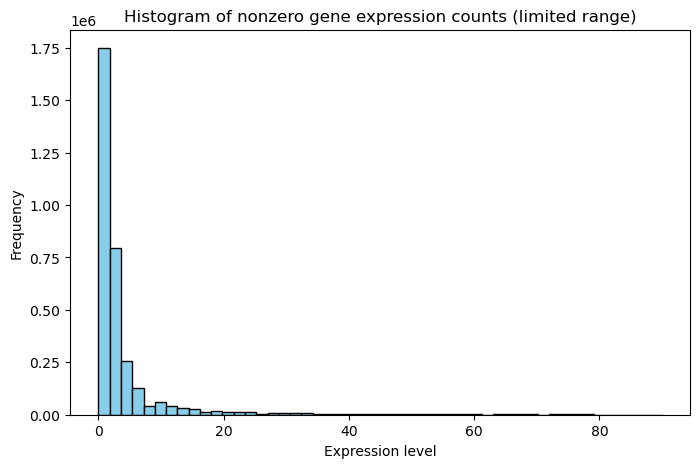

Min: 1
Max: 7451
Mean: 6.897566693802721
Median: 1.0
25th Percentile: 1.0
75th Percentile: 3.0


In [ ]:
X_raw = adata.layers["counts"].toarray()

# Extract nonzero expression values because zeros can dominate the distribution
nonzero_expr = X_raw[X_raw > 0]

# histogram
plt.figure(figsize=(8, 5))
plt.hist(nonzero_expr, bins=50, range=(0, 90), color='skyblue', edgecolor='black')
plt.xlabel("Expression level")
plt.ylabel("Frequency")
plt.title("Histogram of nonzero gene expression counts (limited range)")
plt.show()

# basic stats
print("Min:", np.min(nonzero_expr))
print("Max:", np.max(nonzero_expr))
print("Mean:", np.mean(nonzero_expr))
print("Median:", np.median(nonzero_expr))
print("25th Percentile:", np.percentile(nonzero_expr, 25))
print("75th Percentile:", np.percentile(nonzero_expr, 75))

In [ ]:
def create_graph(adata, cell_features, expr_threshold=2):
    """Constructs a bipartite graph where nodes are cells and genes and edges are based on gene expression levels."""
    data = HeteroData()
    data['cell'].x = cell_features

    # Create random learnable embeddings for gene nodes
    gene_features = torch.randn(len(adata.var_names), 32, requires_grad=True)
    data['gene'].x = gene_features
    
    # Create edges where expression > threshold
    edge_index = [[], []]
    for i in range(n_cells):
        expressed_genes = np.where(X_raw[i, :] > expr_threshold)[0]
        edge_index[0].extend([i] * len(expressed_genes))
        edge_index[1].extend(expressed_genes)

    edge_index = torch.tensor(edge_index, dtype=torch.long)
    data['cell', 'expresses', 'gene'].edge_index = edge_index
    data['gene', 'expressed_by', 'cell'].edge_index = edge_index[[1, 0]]

    # Store cell labels
    data['cell'].y = cell_labels
    return data

In [27]:
# Construct the graph
graph_data = create_graph(adata, cell_features)
print(graph_data)

HeteroData(
  cell={
    x=[42049, 10],
    y=[42049],
  },
  gene={ x=[2000, 32] },
  (cell, expresses, gene)={ edge_index=[2, 1050749] },
  (gene, expressed_by, cell)={ edge_index=[2, 1050749] }
)


### Define and Train GNN 

In [26]:
class HeteroGNN(nn.Module):
    def __init__(self, cell_in_dim, gene_in_dim, hidden_dim, out_dim):
        super(HeteroGNN, self).__init__()
        self.conv1 = HeteroConv({
            ('cell', 'expresses', 'gene'): SAGEConv((cell_in_dim, gene_in_dim), hidden_dim),
            ('gene', 'expressed_by', 'cell'): SAGEConv((gene_in_dim, cell_in_dim), hidden_dim),
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('cell', 'expresses', 'gene'): SAGEConv((hidden_dim, hidden_dim), hidden_dim),
            ('gene', 'expressed_by', 'cell'): SAGEConv((hidden_dim, hidden_dim), hidden_dim),
        }, aggr='mean')

        self.lin = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, data):
        x_dict = {node_type: data[node_type].x for node_type in data.node_types}
        edge_index_dict = {etype: data[etype].edge_index for etype in data.edge_types}
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(val) for key, val in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(val) for key, val in x_dict.items()}
        return self.lin(x_dict['cell']), x_dict

In [ ]:
GNN_model = HeteroGNN(cell_in_dim=latent_dim, gene_in_dim=32, hidden_dim=64, out_dim=2)
optimizer = optim.Adam(GNN_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [28]:
# Training loop
def train():
    GNN_model.train()
    optimizer.zero_grad()
    out, _ = GNN_model(graph_data)
    loss = criterion(out, graph_data['cell'].y)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    GNN_model.eval()
    with torch.no_grad():
        out, _ = GNN_model(graph_data)
        pred = out.argmax(dim=1)
        accuracy = (pred == graph_data['cell'].y).sum().item() / graph_data['cell'].num_nodes
    return accuracy

In [29]:
# Train and evaluate
for epoch in range(50):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {test():.4f}")

Epoch 0, Loss: 0.6845, Accuracy: 0.5809
Epoch 10, Loss: 0.4260, Accuracy: 0.8609
Epoch 20, Loss: 0.3040, Accuracy: 0.8726
Epoch 30, Loss: 0.2728, Accuracy: 0.8874
Epoch 40, Loss: 0.2490, Accuracy: 0.8961


### Interpret Model Using Integrated Gradients
---

Integrated gradients is an attribution method that will help us dissect what cell features are most important for the classification of the GNN. To read more about integrated gradients, visit [this page](https://towardsdatascience.com/interpreting-deep-neural-networks-using-integrated-gradients-f9b8ecdd3c57/). 

In [37]:
def interpret_cell(cell_idx):
    def model_forward_for_cell(interpolated_features):
        """Custom forward function for computing gradients."""
        target_logits = []
        # Loop over each interpolated feature vector (each step along the integration path)
        for step in range(interpolated_features.shape[0]):
            modified_graph = copy.deepcopy(graph_data)

            # Get interpolated feature vector for this step and flatten it to 1D
            current_feature = interpolated_features[step].squeeze()
            
            # Replace target cell's feature vector in the graph data with current feature
            modified_graph['cell'].x[cell_idx] = current_feature

            # Run modified graph through GNN
            model_output, _ = GNN_model(modified_graph)
            
            # Extract the logit for class 1 (normally the second element) of the target cell
            logit_for_class1 = model_output[cell_idx, 1]

                # Add an extra dimension so that all outputs have the same shape and store it
            target_logits.append(logit_for_class1.unsqueeze(0))
        
        # Concatenate outputs from each interpolation step
        return torch.cat(target_logits, dim=0)  # Final shape: (n_steps,)

    ig = IntegratedGradients(model_forward_for_cell)
    # Get original features & ensure baseline has the correct shape
    original_features = graph_data['cell'].x[cell_idx].unsqueeze(0)  # Shape: (1, feature_dim)
    baseline = torch.zeros_like(original_features)  # Same shape as original_features

    attributions, _ = ig.attribute(
        inputs=original_features,
        baselines=baseline,
        n_steps=50,
        internal_batch_size=1,
        return_convergence_delta=True
    )

    return attributions

We can now interpret a sample cell. In practice, you would run this across all cells.


In [38]:
cell_idx = 0
original_cell_features = graph_data['cell'].x[cell_idx].unsqueeze(0)  # shape: [1, feature_dim]

attr = interpret_cell(cell_idx)
print(f"Attributions for Cell {cell_idx}:", attr)

Attributions for Cell 0: tensor([[-0.1024, -0.0779,  0.1756, -0.1589, -0.3500, -0.2631,  0.2669,  0.0307,
          0.0163, -0.7895]], dtype=torch.float64)


### Finally, Compute Gene Gradients with Respect to Latent Representation

By seeing how small changes in the latent vector (which encodes key biological signals) affect the predicted expression of each gene, you can determine which genes are most sensitive to (or influenced by) the latent features.

In [ ]:
# scVI requires normalization information (library size) to accurately decode individual 
# cell latent features back into realistic gene expression values
counts_cell0 = adata.layers["counts"][cell_idx].toarray()
library = torch.tensor(counts_cell0.sum(), dtype=torch.float32).unsqueeze(0)

In [42]:
adata.obs_keys


<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 42049 × 2000
    obs: 'patient', 'site', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'counts'>

In [ ]:
# --- Compute gradients for each gene ---
# Prepare latent features with gradient tracking
original_cell_features_with_grad = original_cell_features.detach().clone()
original_cell_features_with_grad.requires_grad_(True)

# Get predicted gene expression using scVI's decoder
cell_batch = adata.obs['_scvi_batch'][cell_idx]
batch_cats = torch.zeros(1, model.module.n_batch)
batch_cats[0, int(cell_batch)] = 1.0
pred_expr = model.module.decoder("gene", original_cell_features_with_grad, library, batch_cats)
expression = pred_expr[0]  # Shape: [1, n_genes]
n_genes = expression.shape[1]

# Compute gradients for each gene
grad_list = [
    torch.autograd.grad(
        outputs=expression[0, gene_idx],
        inputs=original_cell_features_with_grad,
        retain_graph=True
    )[0].detach().cpu() if expression[0, gene_idx] > 1e-10 
    else torch.zeros_like(original_cell_features_with_grad[0]).cpu()
    for gene_idx in range(n_genes)
]

# Stack gradients into a matrix and remove any extra dimension.
grad_matrix = torch.stack(grad_list).squeeze(1)  # Shape: [n_genes, latent_dim]
# Compute the gradient magnitude for each gene.
grad_magnitude = torch.norm(grad_matrix, dim=1)

/var/folders/2v/kmz2k14x3ggg34rwshstlx480000gn/T/ipykernel_24693/3014170809.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_batch = adata.obs['_scvi_batch'][cell_idx]


# Interpret results

In [47]:
# Get top 10 genes with highest gradient magnitude
top10_indices = torch.argsort(grad_magnitude, descending=True)[:10]
top10_genes = [adata.var_names[int(i)] for i in top10_indices]
print("Top 10 genes with highest gradient magnitude:")
for i, gene in enumerate(top10_genes):
    print(f"{i+1}. {gene}: {grad_magnitude[top10_indices[i]].item():.4f}")

Top 10 genes with highest gradient magnitude:
1. IGLC2: 0.2636
2. IGHG4: 0.1553
3. IGLC3: 0.0872
4. IGKC: 0.0726
5. IGHG1: 0.0673
6. CPM: 0.0663
7. MALAT1: 0.0449
8. IGHG3: 0.0271
9. MT-RNR2: 0.0212
10. IGHM: 0.0140


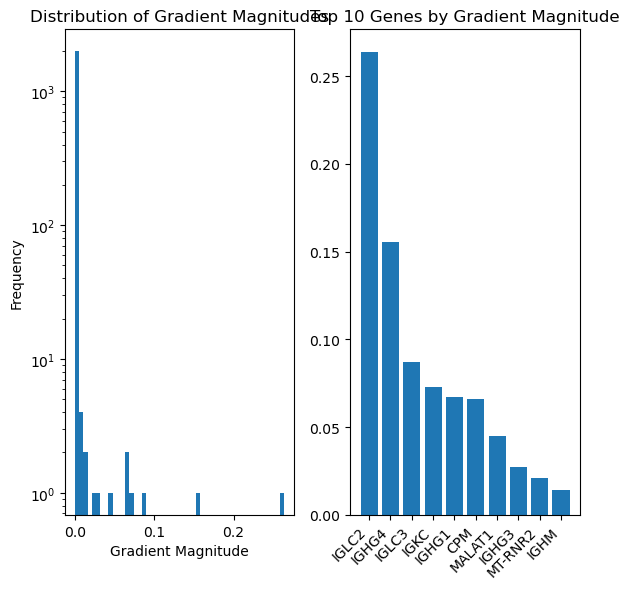

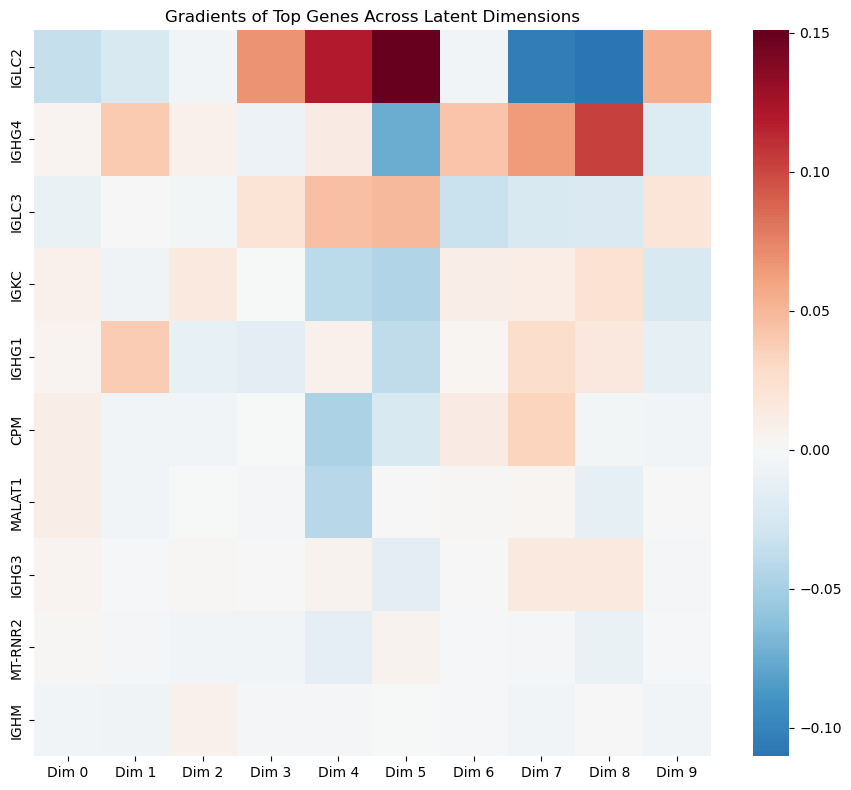


Latent dimension 0 most influences genes:
  1. IGLC2: 0.0358
  2. MALAT1: 0.0106
  3. CPM: 0.0105
  4. IGLC3: 0.0094
  5. IGKC: 0.0071

Latent dimension 1 most influences genes:
  1. IGHG4: 0.0394
  2. IGHG1: 0.0378
  3. IGLC2: 0.0243
  4. IGHM: 0.0067
  5. IGKC: 0.0067

Latent dimension 2 most influences genes:
  1. IGKC: 0.0144
  2. IGHG1: 0.0120
  3. IGHM: 0.0079
  4. IGHG4: 0.0074
  5. JCHAIN: 0.0063

Latent dimension 3 most influences genes:
  1. IGLC2: 0.0679
  2. IGLC3: 0.0208
  3. IGHG1: 0.0159
  4. IGHG4: 0.0086
  5. JCHAIN: 0.0050

Latent dimension 4 most influences genes:
  1. IGLC2: 0.1183
  2. CPM: 0.0479
  3. IGLC3: 0.0456
  4. MALAT1: 0.0411
  5. IGKC: 0.0406

Latent dimension 5 most influences genes:
  1. IGLC2: 0.1508
  2. IGHG4: 0.0739
  3. IGLC3: 0.0493
  4. IGKC: 0.0454
  5. IGHG1: 0.0383

Latent dimension 6 most influences genes:
  1. IGHG4: 0.0434
  2. IGLC3: 0.0330
  3. CPM: 0.0122
  4. IGKC: 0.0092
  5. JCHAIN: 0.0070

Latent dimension 7 most influences genes:


In [ ]:
# Visualize gradients
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))

# Distribution of gradient magnitudes
plt.subplot(1, 2, 1)
plt.hist(grad_magnitude.numpy(), bins=50)
plt.title("Distribution of Gradient Magnitudes")
plt.xlabel("Gradient Magnitude")
plt.ylabel("Frequency")
plt.yscale('log')  # Log scale for better visibility

# Top genes by magnitude
plt.subplot(1, 2, 2)
# Convert tensor to numpy array for plotting
top10_values = grad_magnitude[top10_indices].numpy()
plt.bar(range(10), top10_values)
plt.xticks(range(10), top10_genes, rotation=45, ha='right')
plt.title("Top 10 Genes by Gradient Magnitude")
plt.tight_layout()
plt.show()

# heatmap 
plt.figure(figsize=(9, 8))
top_gene_gradients = grad_matrix[top10_indices].numpy()
sns.heatmap(top_gene_gradients, cmap="RdBu_r", center=0,
            xticklabels=[f"Dim {i}" for i in range(latent_dim)],
            yticklabels=top10_genes)
plt.title("Gradients of Top Genes Across Latent Dimensions")
plt.tight_layout()
plt.show()

# For each latent dimension, find which genes are most influenced
for dim in range(latent_dim):
    dim_influence = abs(grad_matrix[:, dim])
    top5_idx = torch.argsort(dim_influence, descending=True)[:5]
    top5_genes = [adata.var_names[int(i)] for i in top5_idx]
    print(f"\nLatent dimension {dim} most influences genes:")
    for i, gene in enumerate(top5_genes):
        print(f"  {i+1}. {gene}: {dim_influence[top5_idx[i]].item():.4f}")

#### Key Takeaways:
---
- **Immune System Dominance:** Immunoglobulin genes appear across multiple dimensions, indicating that immune-related processes are a major source of variation. This could be due to the presence of different immune cell types, states, or responses.
- **Regulatory Networks:** MALAT1 suggests that the latent space captures regulatory networks, which could be related to gene expression regulation and cancer progression.
- **Metabolic Processes:** The influence of CPM suggests that metabolic processes and immune function are also significant sources of variation.

These insights can guide further analysis, such as functional enrichment or pathway analysis, to better understand the biological processes captured by the latent space.


#### We complete the analysis here and save the artifacts, we may want define a new schema here
---

#### A. Saving the scVI Model:

In [48]:
# Save scVI model
scvi_model_path = "./data/GSE180286_scvi_model.pth"
model.save(scvi_model_path, overwrite=True)
print(f"scVI model saved to {scvi_model_path}")

scVI model saved to ./data/GSE180286_scvi_model.pth


In [49]:
scvi_model_artifact = ln.Artifact(
    scvi_model_path,
    description="Single Cell RNA-seq scVI Model trained [GSE180286], preprocessed and filtered data"
).save()

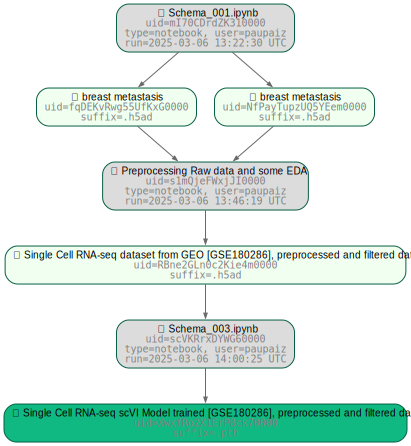

In [50]:
scvi_model_artifact.view_lineage()

#### B. Save GNN Model

In [ ]:

gnn_model_path = "./data/GSE180286_gnn_model.pth"
# Save model state
torch.save(GNN_model.state_dict(), gnn_model_path)
print(f"GNN model saved to {gnn_model_path}")

GNN model saved to ./data/GSE180286_gnn_model.pth


In [52]:
gnn_model_artifact = ln.Artifact(
    gnn_model_path,
    description="Single Cell RNA-seq GNN Model trained [GSE180286], preprocessed and filtered data"
).save()

#### C. Save AnnData

In [53]:
adata

AnnData object with n_obs × n_vars = 42049 × 2000
    obs: 'patient', 'site', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'counts'

In [54]:
adata_with_latent_artifact = ln.Artifact.from_anndata(
    adata,
    description="Single Cell RNA-seq data from GEO [GSE180286], preprocessed and filtered data with Latent Representations"
).save()

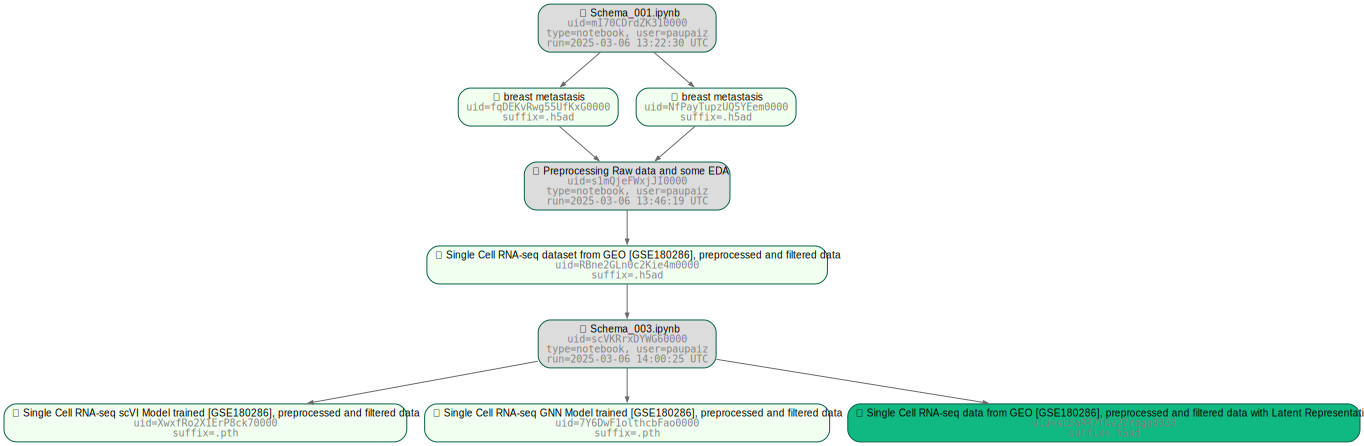

In [55]:
adata_with_latent_artifact.view_lineage()

To summarize, we learned how to leverage Lamin schemas and additional entities for reproducible biomedical data analysis. 